In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

In [6]:
f_path=r'/Users/91950/Documents/293C-Add/movies_metadata.csv'
md = pd. read_csv(f_path)
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [7]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [8]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [9]:
m = vote_counts.quantile(0.95)
m

434.0

In [10]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [11]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [12]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [13]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [14]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [15]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [16]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

def build_chart(genre, percentile=0.85):
    # Filter the dataframe for the selected genre
    df = gen_md[gen_md['genre'] == genre]
    
    # Extract necessary columns and clean data
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    # Select qualified movies based on vote count and vote average thresholds
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    # Calculate weighted rating (wr)
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    
    # Sort the movies by weighted rating and select top 250
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    # Ensure the 'popularity' column is numeric, and drop rows with NaN values in popularity
    qualified['popularity'] = pd.to_numeric(qualified['popularity'], errors='coerce')
    qualified = qualified.dropna(subset=['popularity'])
    
    # Create a pie chart based on 'popularity' (you can choose another feature like 'vote_average' or 'wr' if desired)
    popularity_bins = ['Low', 'Medium', 'High']
    # Define thresholds for categorizing popularity
    qualified['popularity_category'] = pd.cut(qualified['popularity'], bins=[0, 20, 60, 100], labels=popularity_bins)
    
    # Get the count of each popularity category
    popularity_counts = qualified['popularity_category'].value_counts()
    
    # Plot the pie chart with multiple colors
    plt.figure(figsize=(7, 7))
    plt.pie(popularity_counts, labels=popularity_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    plt.title(f'Popularity Distribution of {genre} Movies (Top 250 by Weighted Rating)', fontsize=14)
    plt.show()
    
    # Return the filtered DataFrame
    return qualified



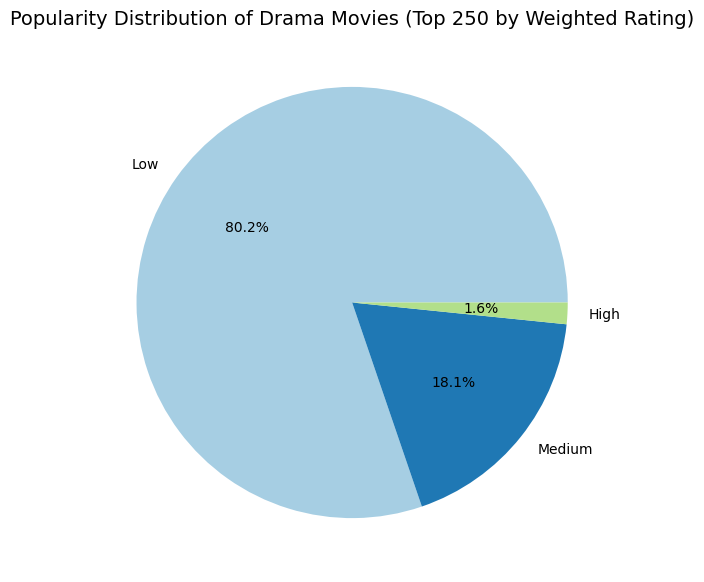

,title,year,vote_count,vote_average,popularity,wr,popularity_category
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.607205,Medium
12481,The Dark Knight,2008,12269,8,123.167259,7.983111,NaN
22879,Interstellar,2014,11187,8,32.213481,7.981489,Medium
2843,Fight Club,1999,9678,8,63.869599,7.978628,High
314,The Shawshank Redemption,1994,8358,8,51.645403,7.975286,Medium
351,Forrest Gump,1994,8147,8,48.307194,7.974653,Medium
834,The Godfather,1972,6024,8,41.109264,7.965843,Medium
24860,The Imitation Game,2014,5895,8,31.595940,7.965106,Medium
359,The Lion King,1994,5520,8,21.605761,7.962771,Medium
18465,The Intouchables,2011,5410,8,16.086919,7.962025,Low


In [20]:
build_chart('Drama').head(25)

In [25]:
f_path=r'/Users/91950/Documents/293C-Add/links_small.csv'
links_small = pd.read_csv(f_path)
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [26]:
md = md.drop([19730, 29503, 35587])

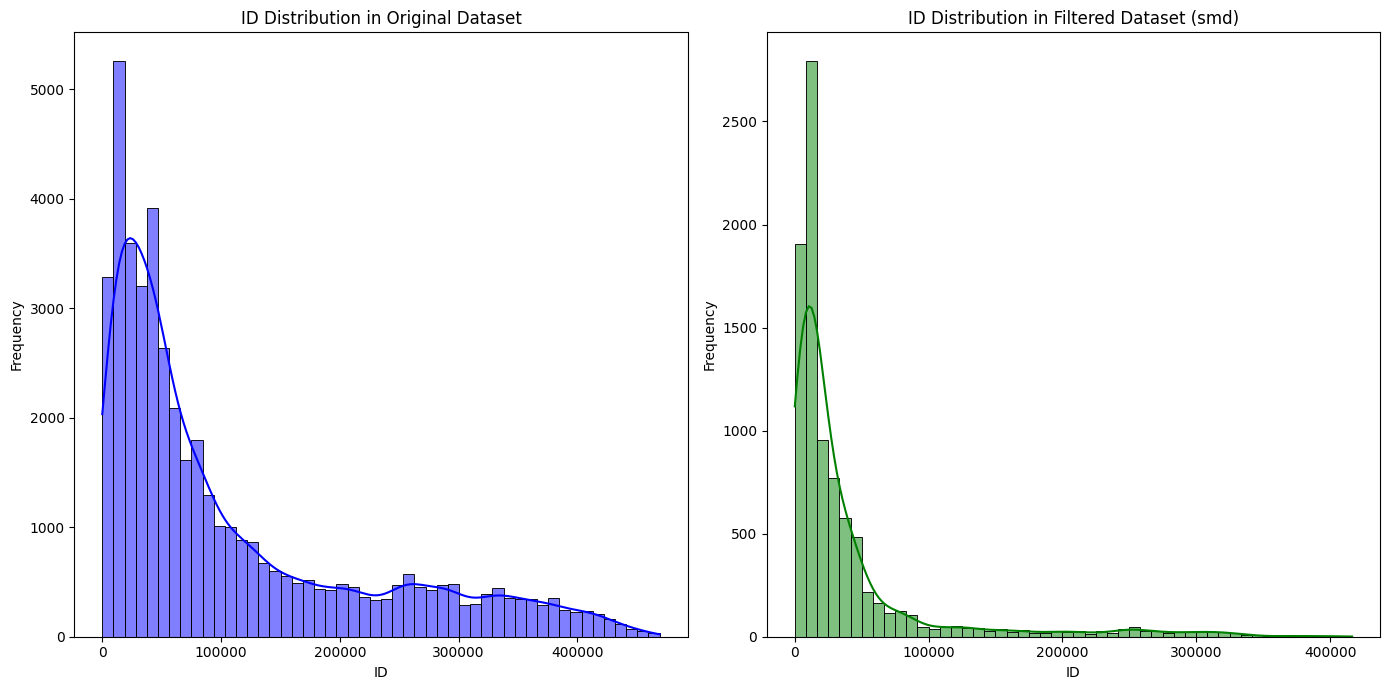

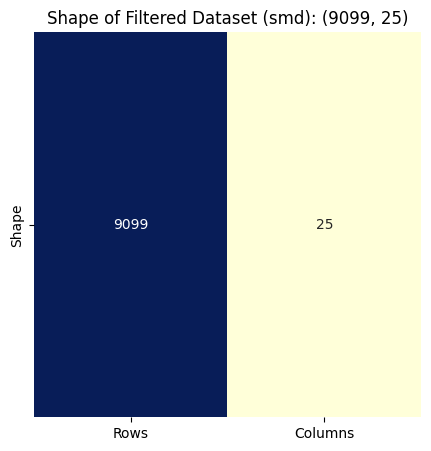

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming md is a DataFrame and links_small is a list or array of IDs
md['id'] = md['id'].astype('int')

# Filter the dataset based on 'id' in 'links_small'
smd = md[md['id'].isin(links_small)]

# Plot the distribution of 'id' in the original dataset and the filtered one
plt.figure(figsize=(14, 7))

# Plot the distribution of 'id' in the original dataset
plt.subplot(1, 2, 1)
sns.histplot(md['id'], bins=50, kde=True, color='blue')
plt.title("ID Distribution in Original Dataset")
plt.xlabel("ID")
plt.ylabel("Frequency")

# Plot the distribution of 'id' in the filtered dataset (smd)
plt.subplot(1, 2, 2)
sns.histplot(smd['id'], bins=50, kde=True, color='green')
plt.title("ID Distribution in Filtered Dataset (smd)")
plt.xlabel("ID")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Now print the shape of the filtered dataset as a graph representation
smd_shape = smd.shape
plt.figure(figsize=(5, 5))
sns.heatmap([[smd_shape[0], smd_shape[1]]], annot=True, fmt='d', cmap="YlGnBu", cbar=False,
            xticklabels=["Rows", "Columns"], yticklabels=["Shape"])
plt.title(f"Shape of Filtered Dataset (smd): {smd_shape}")
plt.show()


In [37]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.01, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.        , 0.        , ..., 0.        , 0.06566461,
       0.        ])

In [38]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

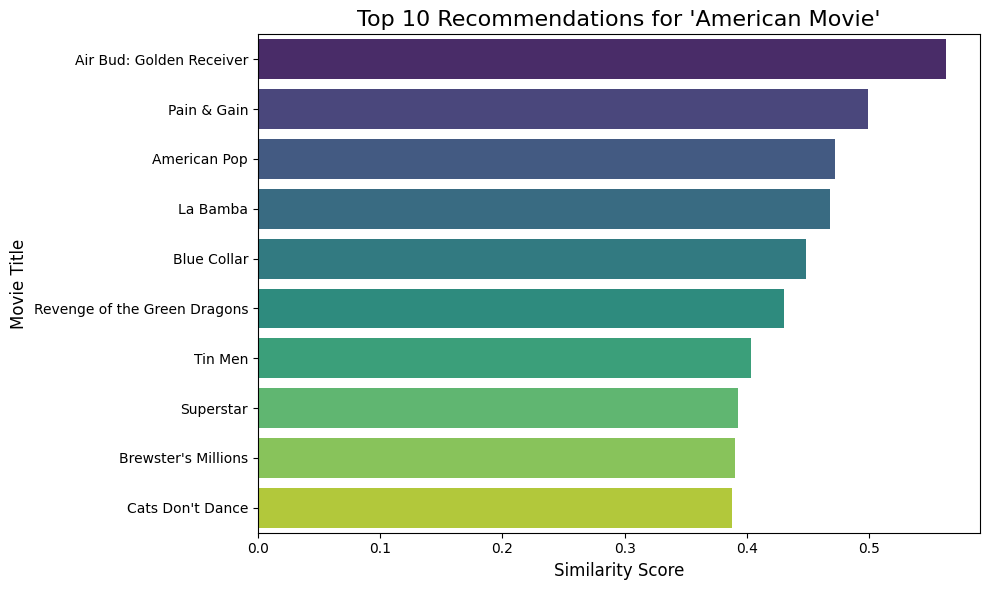

,Movie Title,Similarity Score
1707,Air Bud: Golden Receiver,0.562491
8283,Pain & Gain,0.499357
2973,American Pop,0.472206
2773,La Bamba,0.467615
2645,Blue Collar,0.448342
8623,Revenge of the Green Dragons,0.430133
1129,Tin Men,0.403227
2329,Superstar,0.392529
3208,Brewster's Millions,0.389989
1198,Cats Don't Dance,0.388185


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_recommendations_with_graph(title, top_n=10):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the similarity scores for the movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top N similar movie indices (excluding the original movie)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    
    # Get the corresponding movie titles and similarity scores
    recommended_titles = titles.iloc[movie_indices]
    similarity_scores = [x[1] for x in sim_scores]
    
    # Create a DataFrame for easier manipulation
    recommendations_df = pd.DataFrame({
        'Movie Title': recommended_titles,
        'Similarity Score': similarity_scores
    })
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    
    # Create a horizontal bar plot using seaborn
    sns.barplot(x='Similarity Score', y='Movie Title', data=recommendations_df, palette='viridis')
    
    # Title and labels
    plt.title(f"Top {top_n} Recommendations for '{title}'", fontsize=16)
    plt.xlabel('Similarity Score', fontsize=12)
    plt.ylabel('Movie Title', fontsize=12)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

    return recommendations_df

# Example usage
get_recommendations_with_graph('American Movie')


In [64]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the data
f_path = r'/Users/91950/Documents/293C-Add/ratings_small.csv'
ratings = pd.read_csv(f_path)

# Split the data into train and test sets using sklearn's train_test_split
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

# Setup Reader and load the dataset
reader = Reader()
train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
test_data = Dataset.load_from_df(test_df[['userId', 'movieId', 'rating']], reader)

# Check the first few rows of the ratings data
ratings.head()


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [66]:
svd = SVD()
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8939  0.8967  0.8951  0.9005  0.8903  0.8953  0.0033  
MAE (testset)     0.6869  0.6907  0.6895  0.6930  0.6843  0.6889  0.0030  
Fit time          1.28    1.63    1.62    1.34    1.34    1.44    0.15    
Test time         0.48    0.25    0.20    0.16    0.13    0.24    0.12    


In [68]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [69]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [70]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.8230487751680573, details={'was_impossible': False})

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8914  0.9035  0.8983  0.8944  0.9001  0.8975  0.0043  
MAE (testset)     0.6846  0.6945  0.6921  0.6899  0.6932  0.6908  0.0035  
Fit time          1.31    1.26    1.14    1.28    1.24    1.25    0.06    
Test time         0.17    0.13    0.16    0.16    0.42    0.21    0.11    


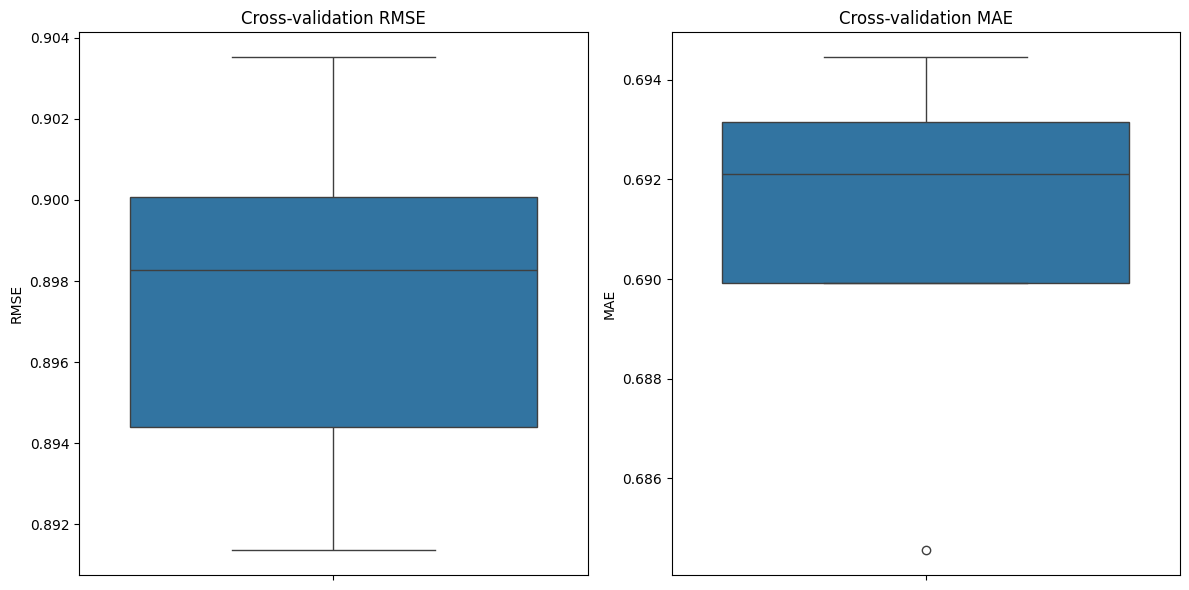

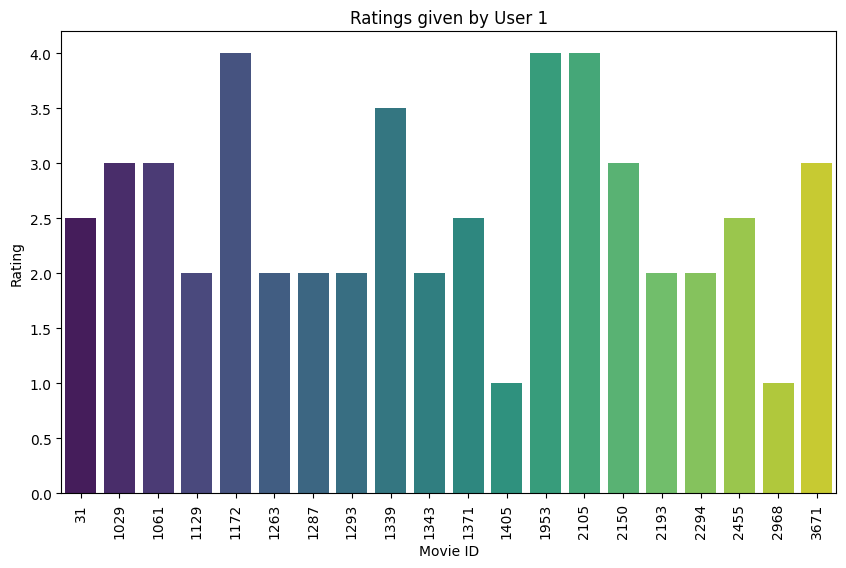

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
import pandas as pd

# Load the data
f_path = r'/Users/91950/Documents/293C-Add/ratings_small.csv'
ratings = pd.read_csv(f_path)

# Setup Reader and load the dataset
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Create an SVD model
svd = SVD()

# Evaluate the model using cross-validation
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Plot RMSE and MAE results from cross-validation
cv_results = pd.DataFrame(results)
plt.figure(figsize=(12, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
sns.boxplot(data=cv_results['test_rmse'])
plt.title('Cross-validation RMSE')
plt.ylabel('RMSE')

# Plot MAE
plt.subplot(1, 2, 2)
sns.boxplot(data=cv_results['test_mae'])
plt.title('Cross-validation MAE')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

# Train the model on the full training set
trainset = data.build_full_trainset()
svd.fit(trainset)

# Show ratings for userId 1
user_ratings = ratings[ratings['userId'] == 1]

# Plot a bar chart of ratings for userId 1
plt.figure(figsize=(10, 6))
sns.barplot(x='movieId', y='rating', data=user_ratings, palette='viridis')
plt.title('Ratings given by User 1')
plt.xlabel('Movie ID')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.show()
